## For문을 통해 수정한 코드

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
from tools_ryu import mytool

In [2]:
d = pd.read_pickle("coinmarketcap_data/coinmarketcap_data.pickle")
vol = pd.pivot_table(data=d,
                     values="vol", 
                     index="date", 
                     columns="coin_id")

vol_mask = (vol.rolling(window=30).mean() > 1_000_000).replace({True:1,
                                                                 False: np.nan})

In [3]:
mktcap = pd.read_pickle("mktcap_pp2.pickle")
price = pd.read_pickle("close_pp2.pickle") \
          .replace(0, np.nan)

daily_rtn = price.pct_change(fill_method=None)
mktcap_mask = (mktcap.rolling(window=30).mean() > 1_000_000) \
                     .replace({True:1,
                               False:np.nan})

mktcap_screened = (mktcap * mktcap_mask * vol_mask)

In [4]:
# 시작일 찾기
start_idx = (mktcap_screened.isna().sum(1) < 10616).replace(False,np.nan).dropna().index[0]

# weight 계산
weight = mktcap_screened.loc[start_idx:].apply(lambda x: x / np.nansum(x), axis=1)

# 마켓 인덱스 만들기
mkt_index = (daily_rtn*weight.shift(1)).sum(1)

In [5]:
start_idx

Timestamp('2013-12-27 00:00:00')

Cross-Sectional-Momentum : Weekly Rebalancing

In [6]:
weekly_mktcap = mktcap_screened.loc[start_idx:].resample("W").last()
weekly_rtn = price.loc[start_idx:].pct_change(7,fill_method=None) \
                  .resample("W").last()
weekly_price = price.loc[start_idx:].resample("W").last()
weekly_vol_mask = vol_mask.loc[start_idx:].resample("W").last()

In [7]:
# Momentum 그룹을 구하기 위해서 필요함
weekly_rtn_pp = weekly_rtn * np.sign(weekly_mktcap) * weekly_vol_mask

In [8]:
# 언제부터 시작하는 지 찾자 (최소 100개의 코인이 필요)
cnt = weekly_rtn_pp.count(1)
more100 = cnt.loc[cnt > 99] # 여기서 start date가 나온다
start = more100.index[0]
more100

date
2017-12-03    110
2017-12-10    120
2017-12-17    144
2017-12-24    165
2017-12-31    180
             ... 
2023-03-19    616
2023-03-26    615
2023-04-02    606
2023-04-09    602
2023-04-16    596
Freq: W-SUN, Length: 281, dtype: int64

In [9]:
weekly_rtn_sample_pp = weekly_rtn_pp.loc[start:]
weekly_mktcap_sample = weekly_mktcap.loc[start:]
weekly_price_sample = weekly_price.loc[start:]

In [10]:
# rank를 계산해줍니다
rank = weekly_rtn_sample_pp.rank(axis=1, method="first")

# rank가 존재하는 코인의 수를 구합니다
coin_count = rank.count(axis=1)

# 그룹별로 동일한 코인 수를 포함하기 위해 각 그룹의 rank thresh를 생성해줍니다
rank_thresh = coin_count.apply(lambda x: [i for i in range(0,x, x//5)])

t1 = rank_thresh.apply(lambda x: x[1])
t2 = rank_thresh.apply(lambda x: x[2])
t3 = rank_thresh.apply(lambda x: x[3])
t4 = rank_thresh.apply(lambda x: x[4])

rank_thresh

date
2017-12-03             [0, 22, 44, 66, 88]
2017-12-10             [0, 24, 48, 72, 96]
2017-12-17       [0, 28, 56, 84, 112, 140]
2017-12-24            [0, 33, 66, 99, 132]
2017-12-31           [0, 36, 72, 108, 144]
                          ...             
2023-03-19    [0, 123, 246, 369, 492, 615]
2023-03-26         [0, 123, 246, 369, 492]
2023-04-02    [0, 121, 242, 363, 484, 605]
2023-04-09    [0, 120, 240, 360, 480, 600]
2023-04-16    [0, 119, 238, 357, 476, 595]
Freq: W-SUN, Length: 281, dtype: object

In [11]:
g1_mask = rank.apply(lambda x: x <= t1, axis=0) \
              .replace({True:1, False:np.nan})
g2_mask = rank.apply(lambda x: (t1 < x)&(x <= t2), axis=0) \
              .replace({True:1, False:np.nan})
g3_mask = rank.apply(lambda x: (t2 < x)&(x <= t3), axis=0) \
              .replace({True:1, False:np.nan})
g4_mask = rank.apply(lambda x: (t3 < x)&(x <= t4), axis=0) \
              .replace({True:1, False:np.nan})
g5_mask = rank.apply(lambda x: x > t4, axis=0) \
              .replace({True:1, False:np.nan})           

In [12]:
# 각 그룹별 weight를 생성
weight_g1 = (g1_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g2 = (g2_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g3 = (g3_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g4 = (g4_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g5 = (g5_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)

# 여기까지가 t기에 weight를 구하는 과정까지다 
each_weight = {"Q1":weight_g1,
               "Q2":weight_g2,
               "Q3":weight_g3,
               "Q4":weight_g4,
               "Q5":weight_g5}

In [13]:
final_value = {}

for key, weight_matrix in tqdm(each_weight.items(),desc="Processing dictionary"):
    pf_value = 1
    strategy_rtn = {}

    for t in weight_matrix.index:
        dollar_value = weight_matrix.loc[t] * pf_value    # 포트폴리오가 담을 각 코인의 달러가치

        # 여기까지가 t기 close에 momentum을 계산하고, 몇 개의 코인을 살지 결정한 것이다
        ## t+1기 부터 t+7기 close까지 수익을 계산해야 한다
        t_1, t_7 = t + pd.Timedelta(days=1), t + pd.Timedelta(days=7)
        for date in pd.date_range(t_1, t_7):
            if date > weight_matrix.index[-1]: # 우리가 가진 데이터의 기간 밖이면 break
                break
            dollar_value = dollar_value * (1+daily_rtn.loc[date]) #코인의 dollar value 변화를 추적
            pf_value = dollar_value.sum()
            strategy_rtn[str(date.strftime("%Y-%m-%d"))] = pf_value
    # 저장
    pf_save = pd.Series(strategy_rtn)
    pf_save.index = pd.to_datetime(pf_save.index)
    pf_save[pf_save.index[0] - pd.Timedelta(days=1)] = 1 # 투자 시작일 포트폴리오 가치를 1로 셋팅
    final_value[key] = pf_save.sort_index().pct_change().fillna(0)

Processing dictionary: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


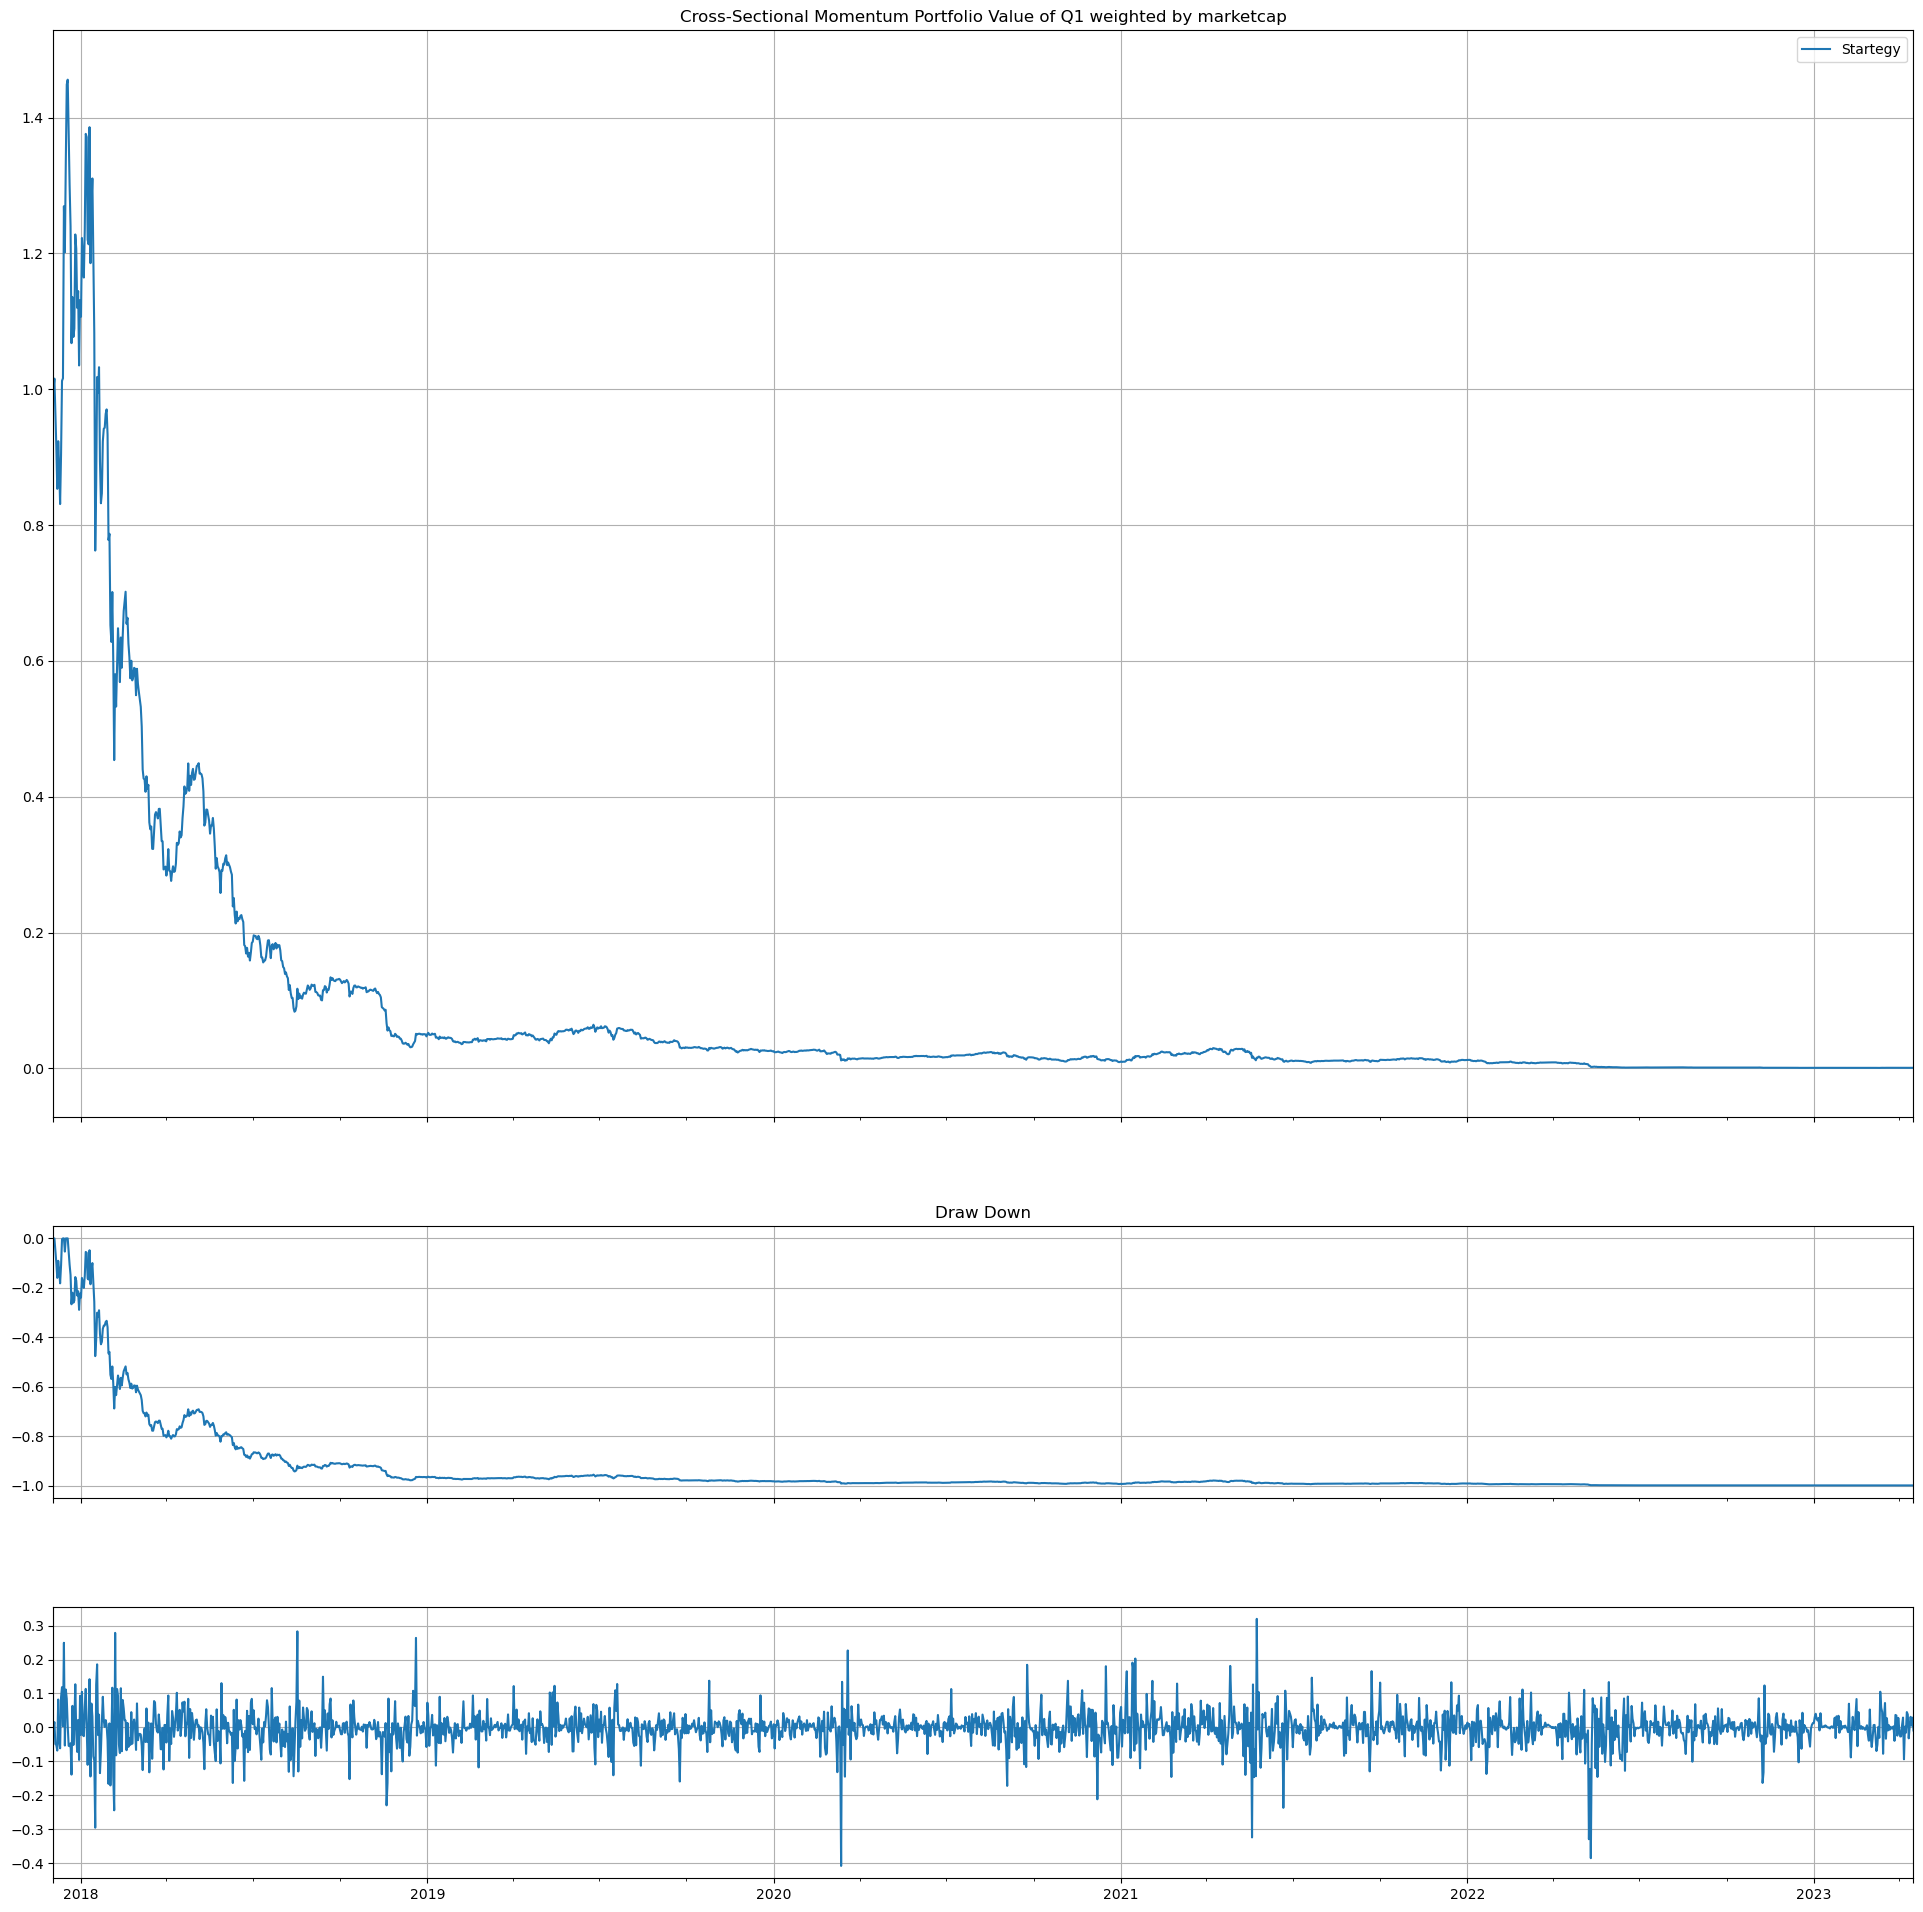

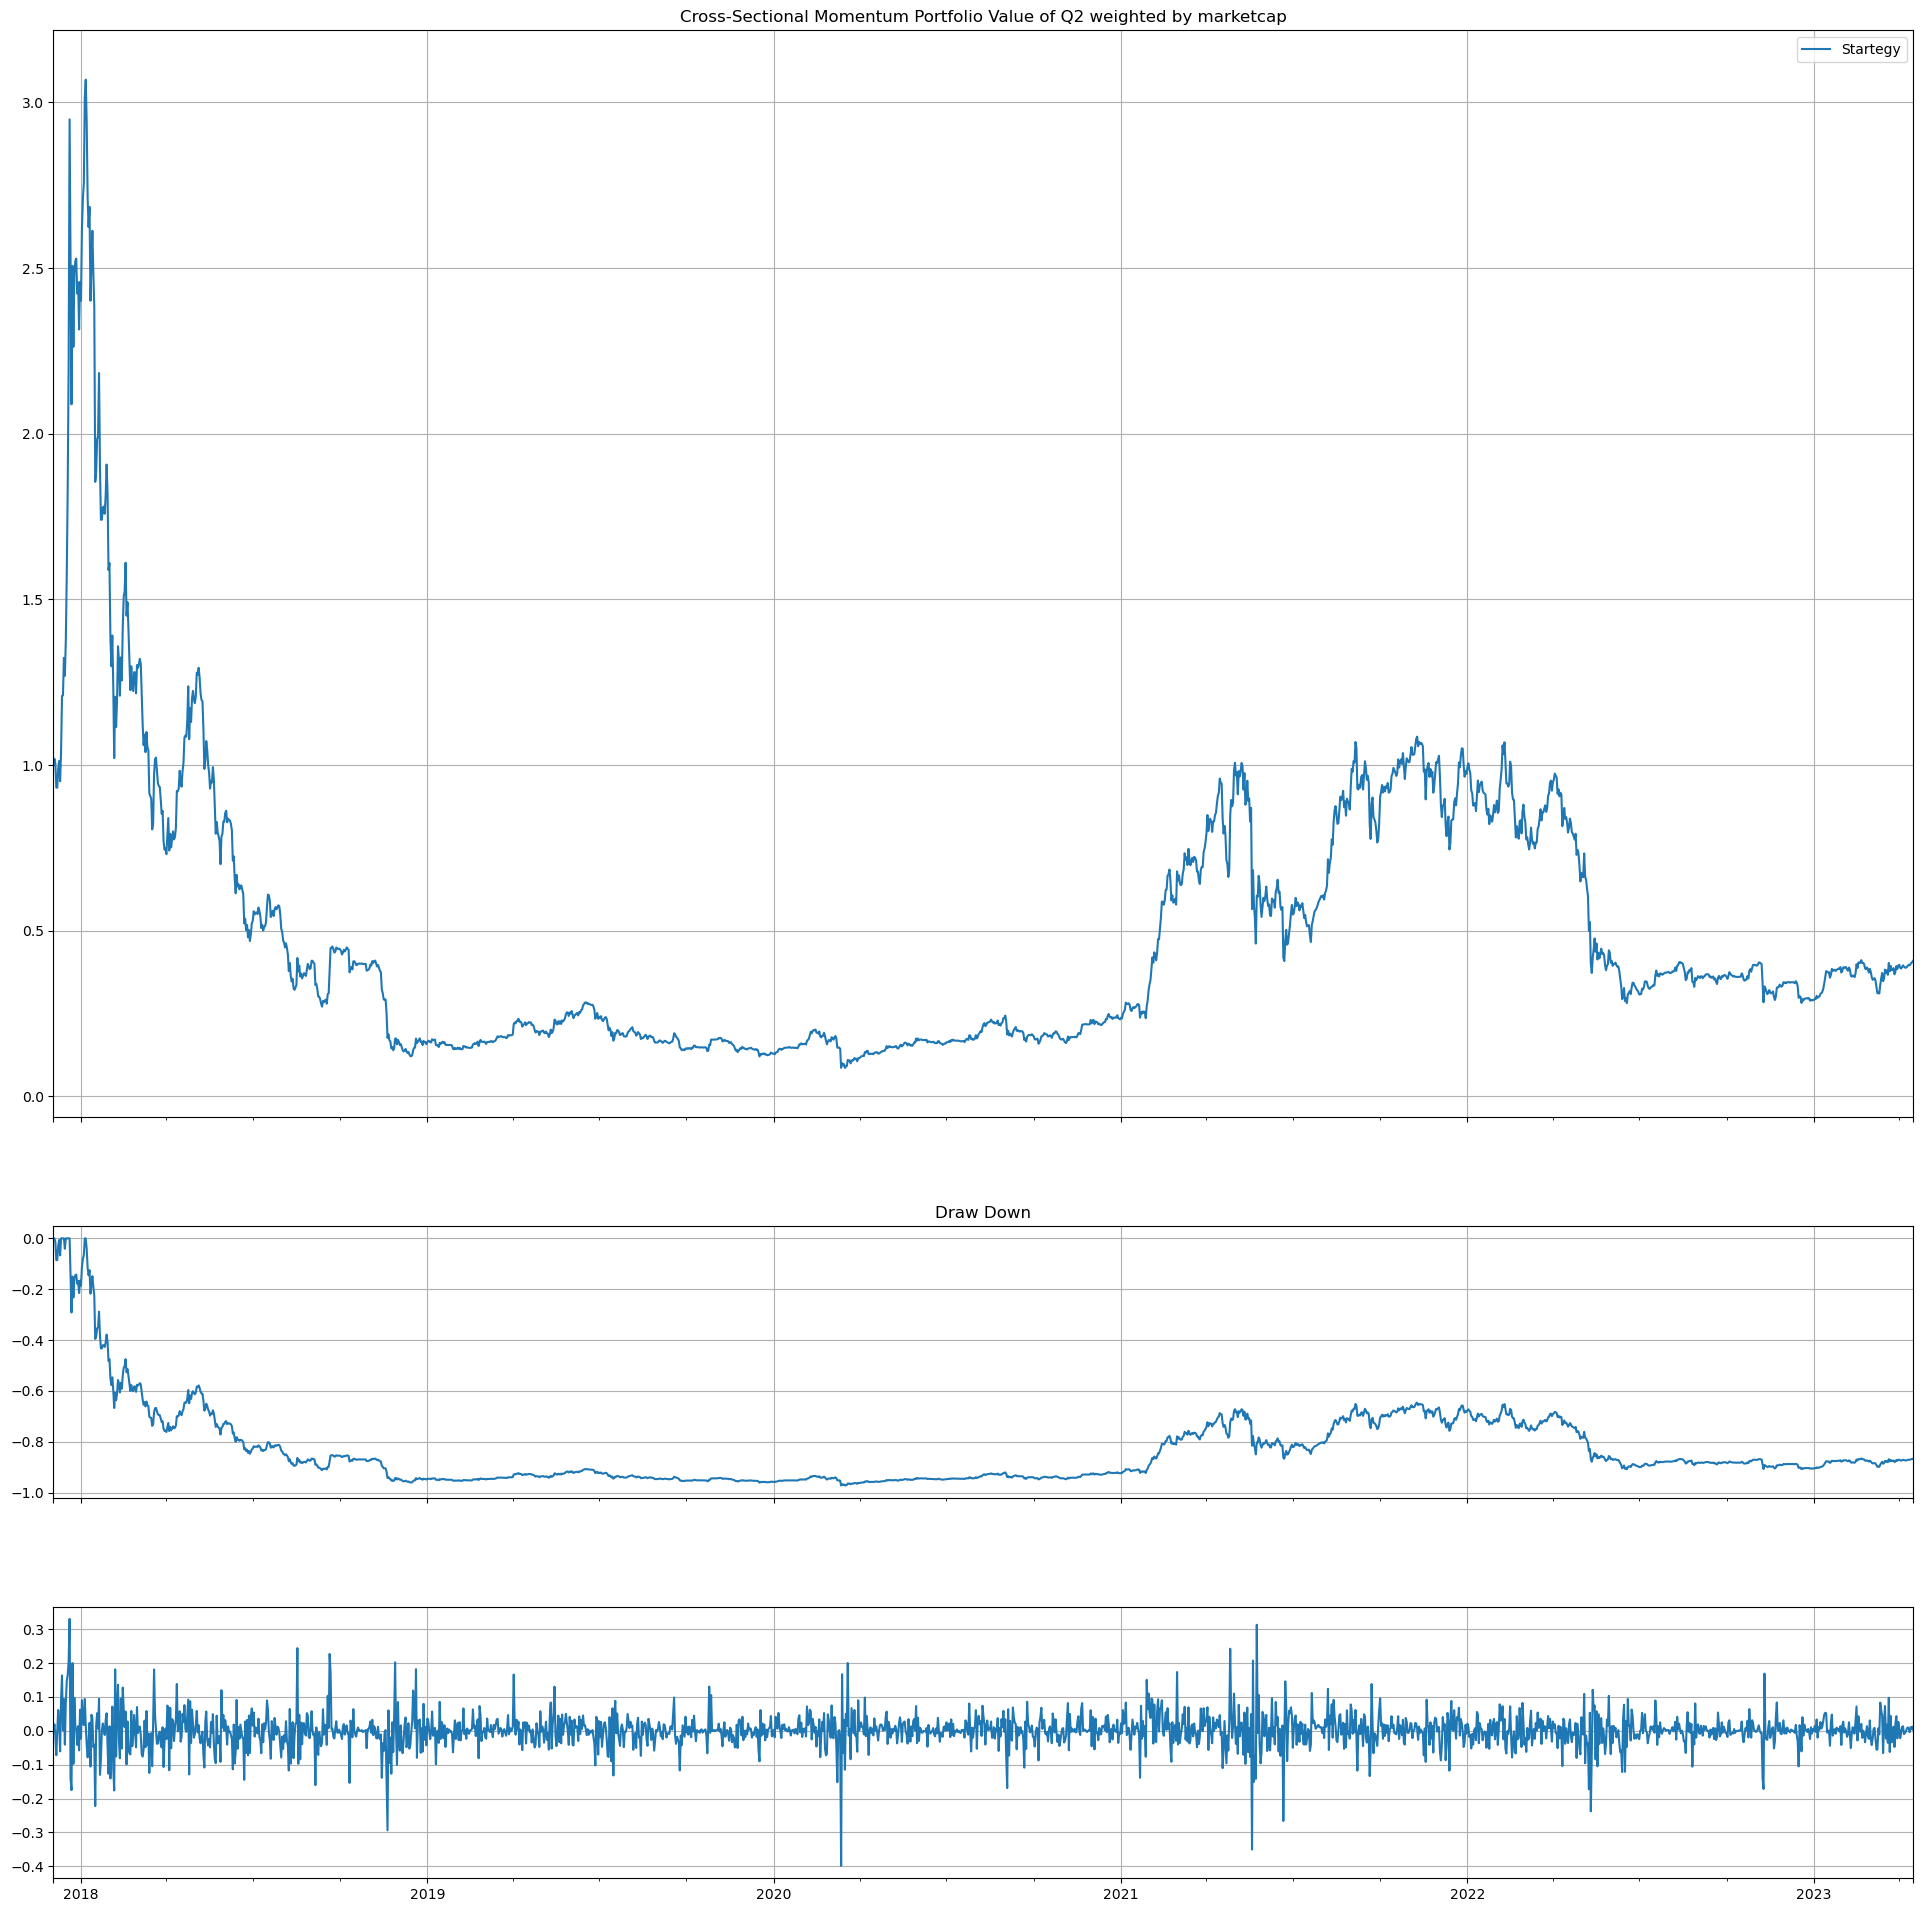

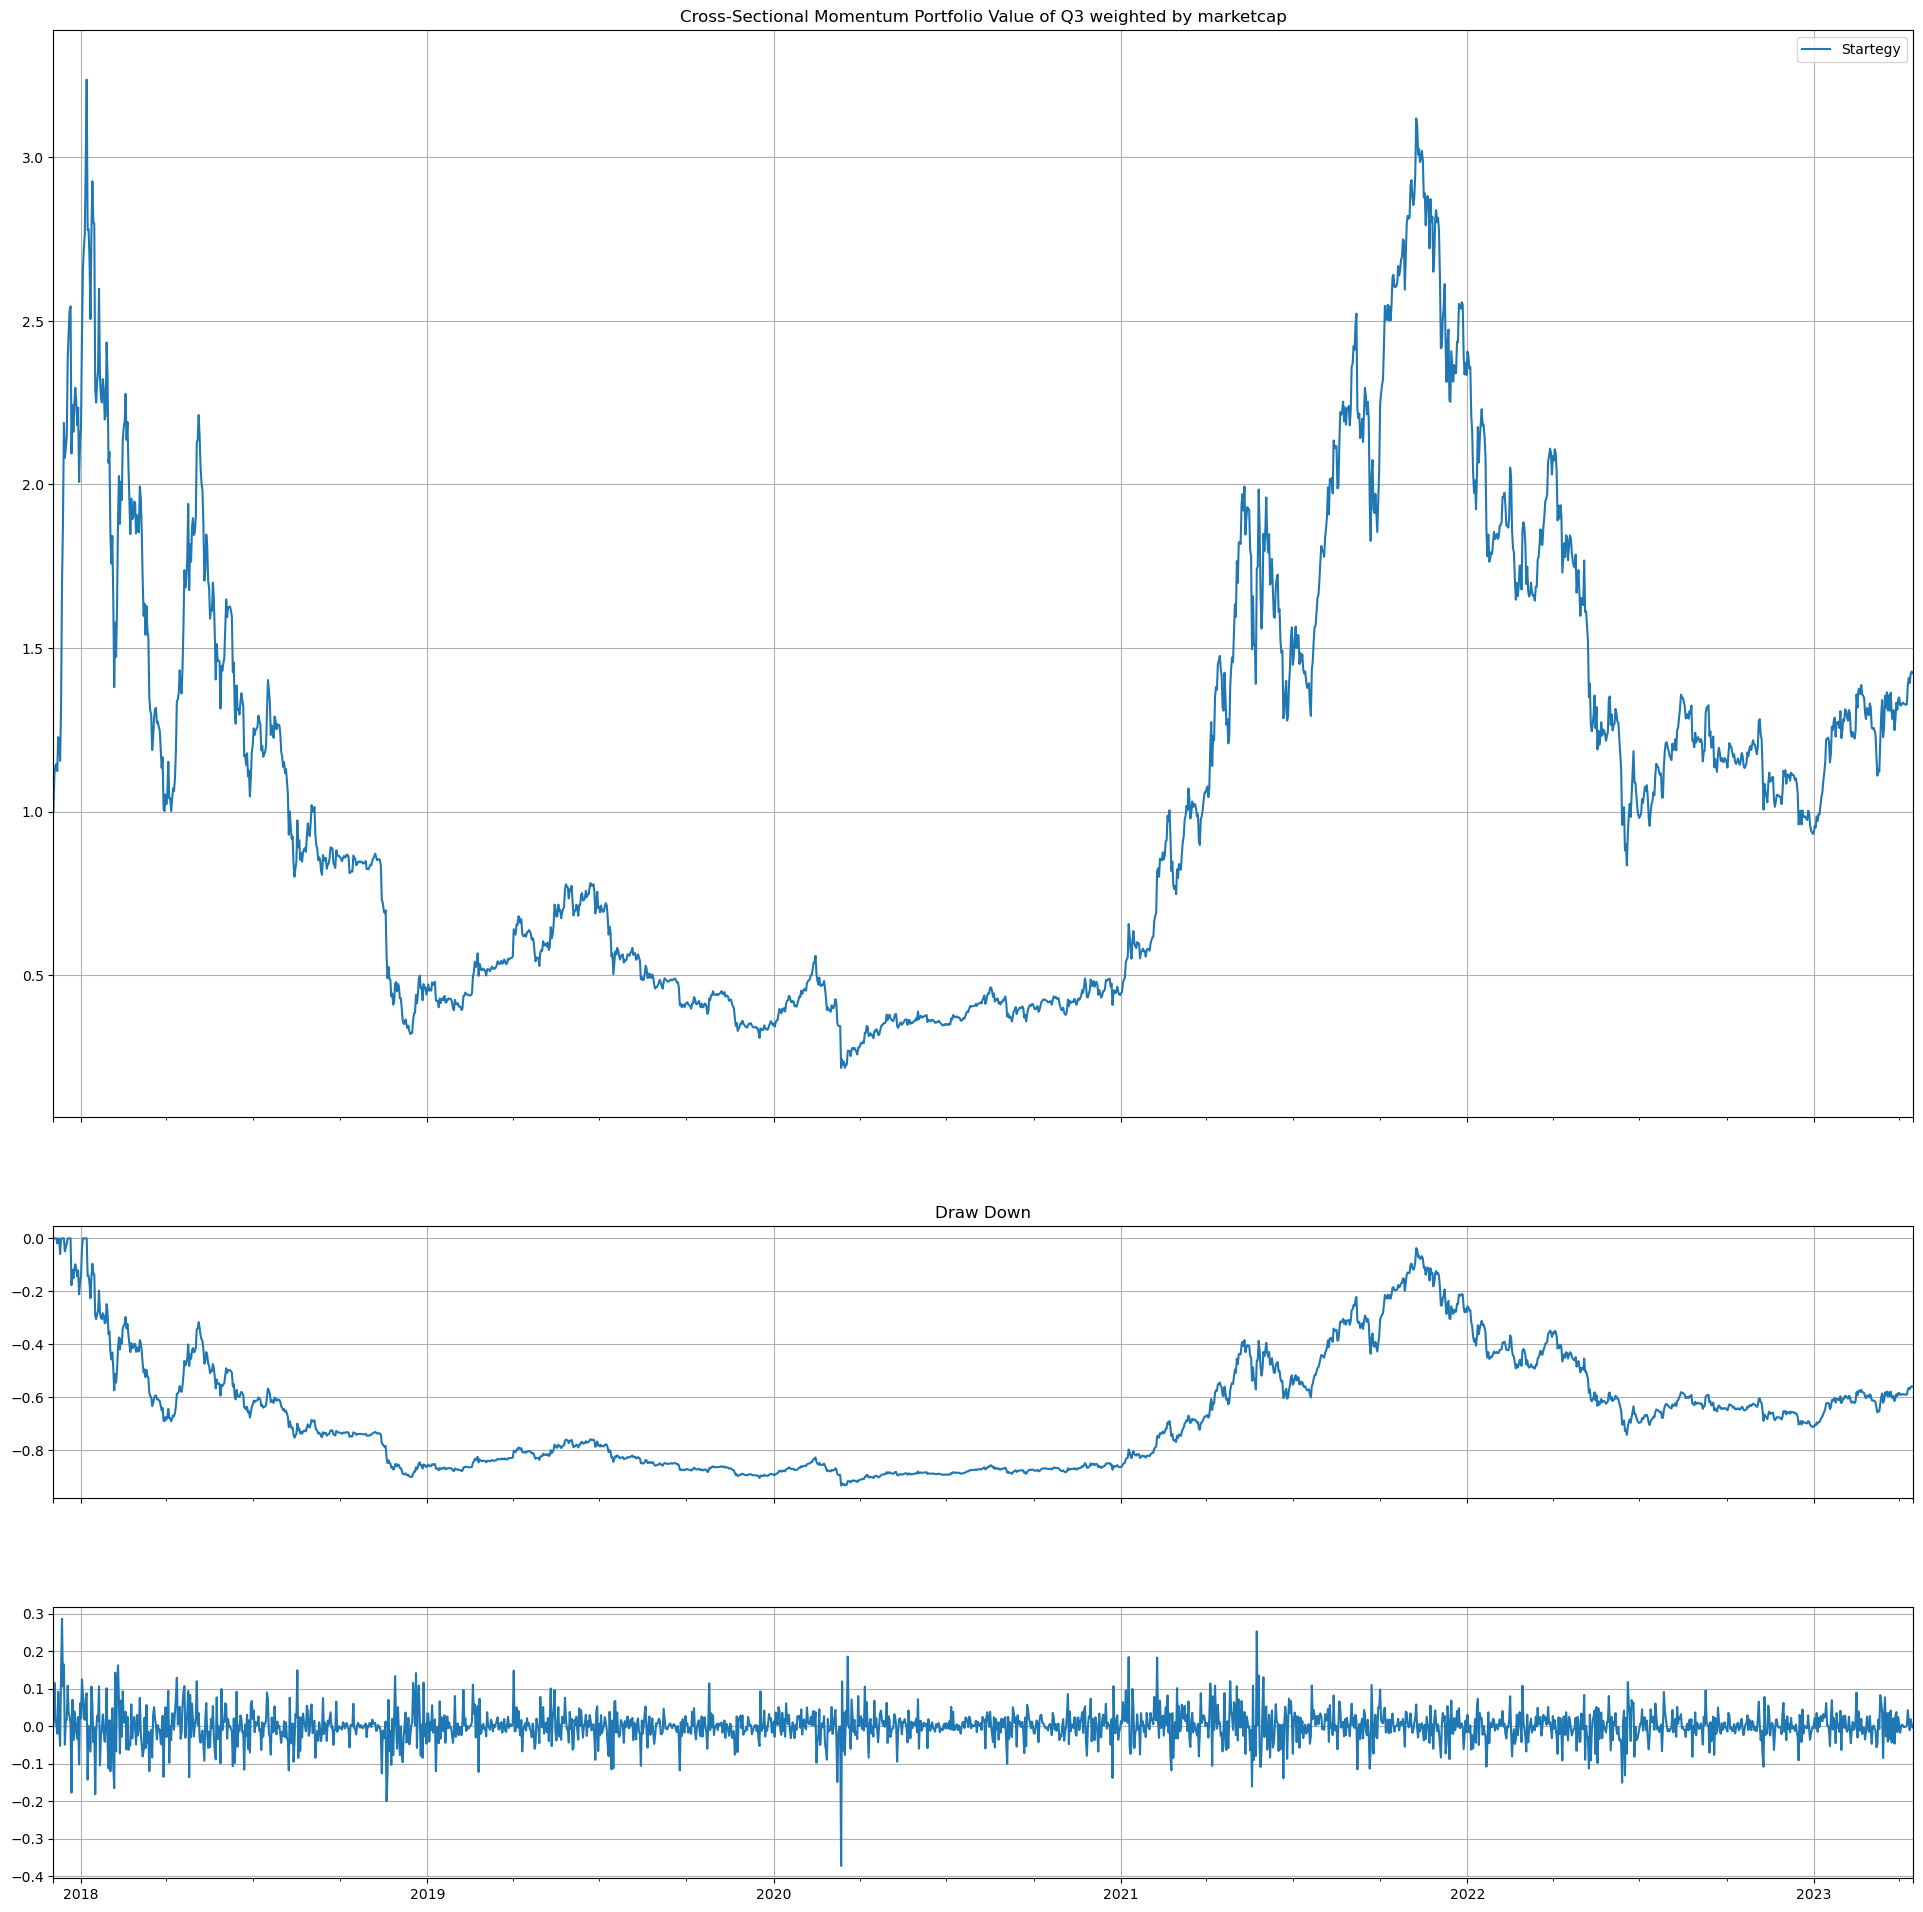

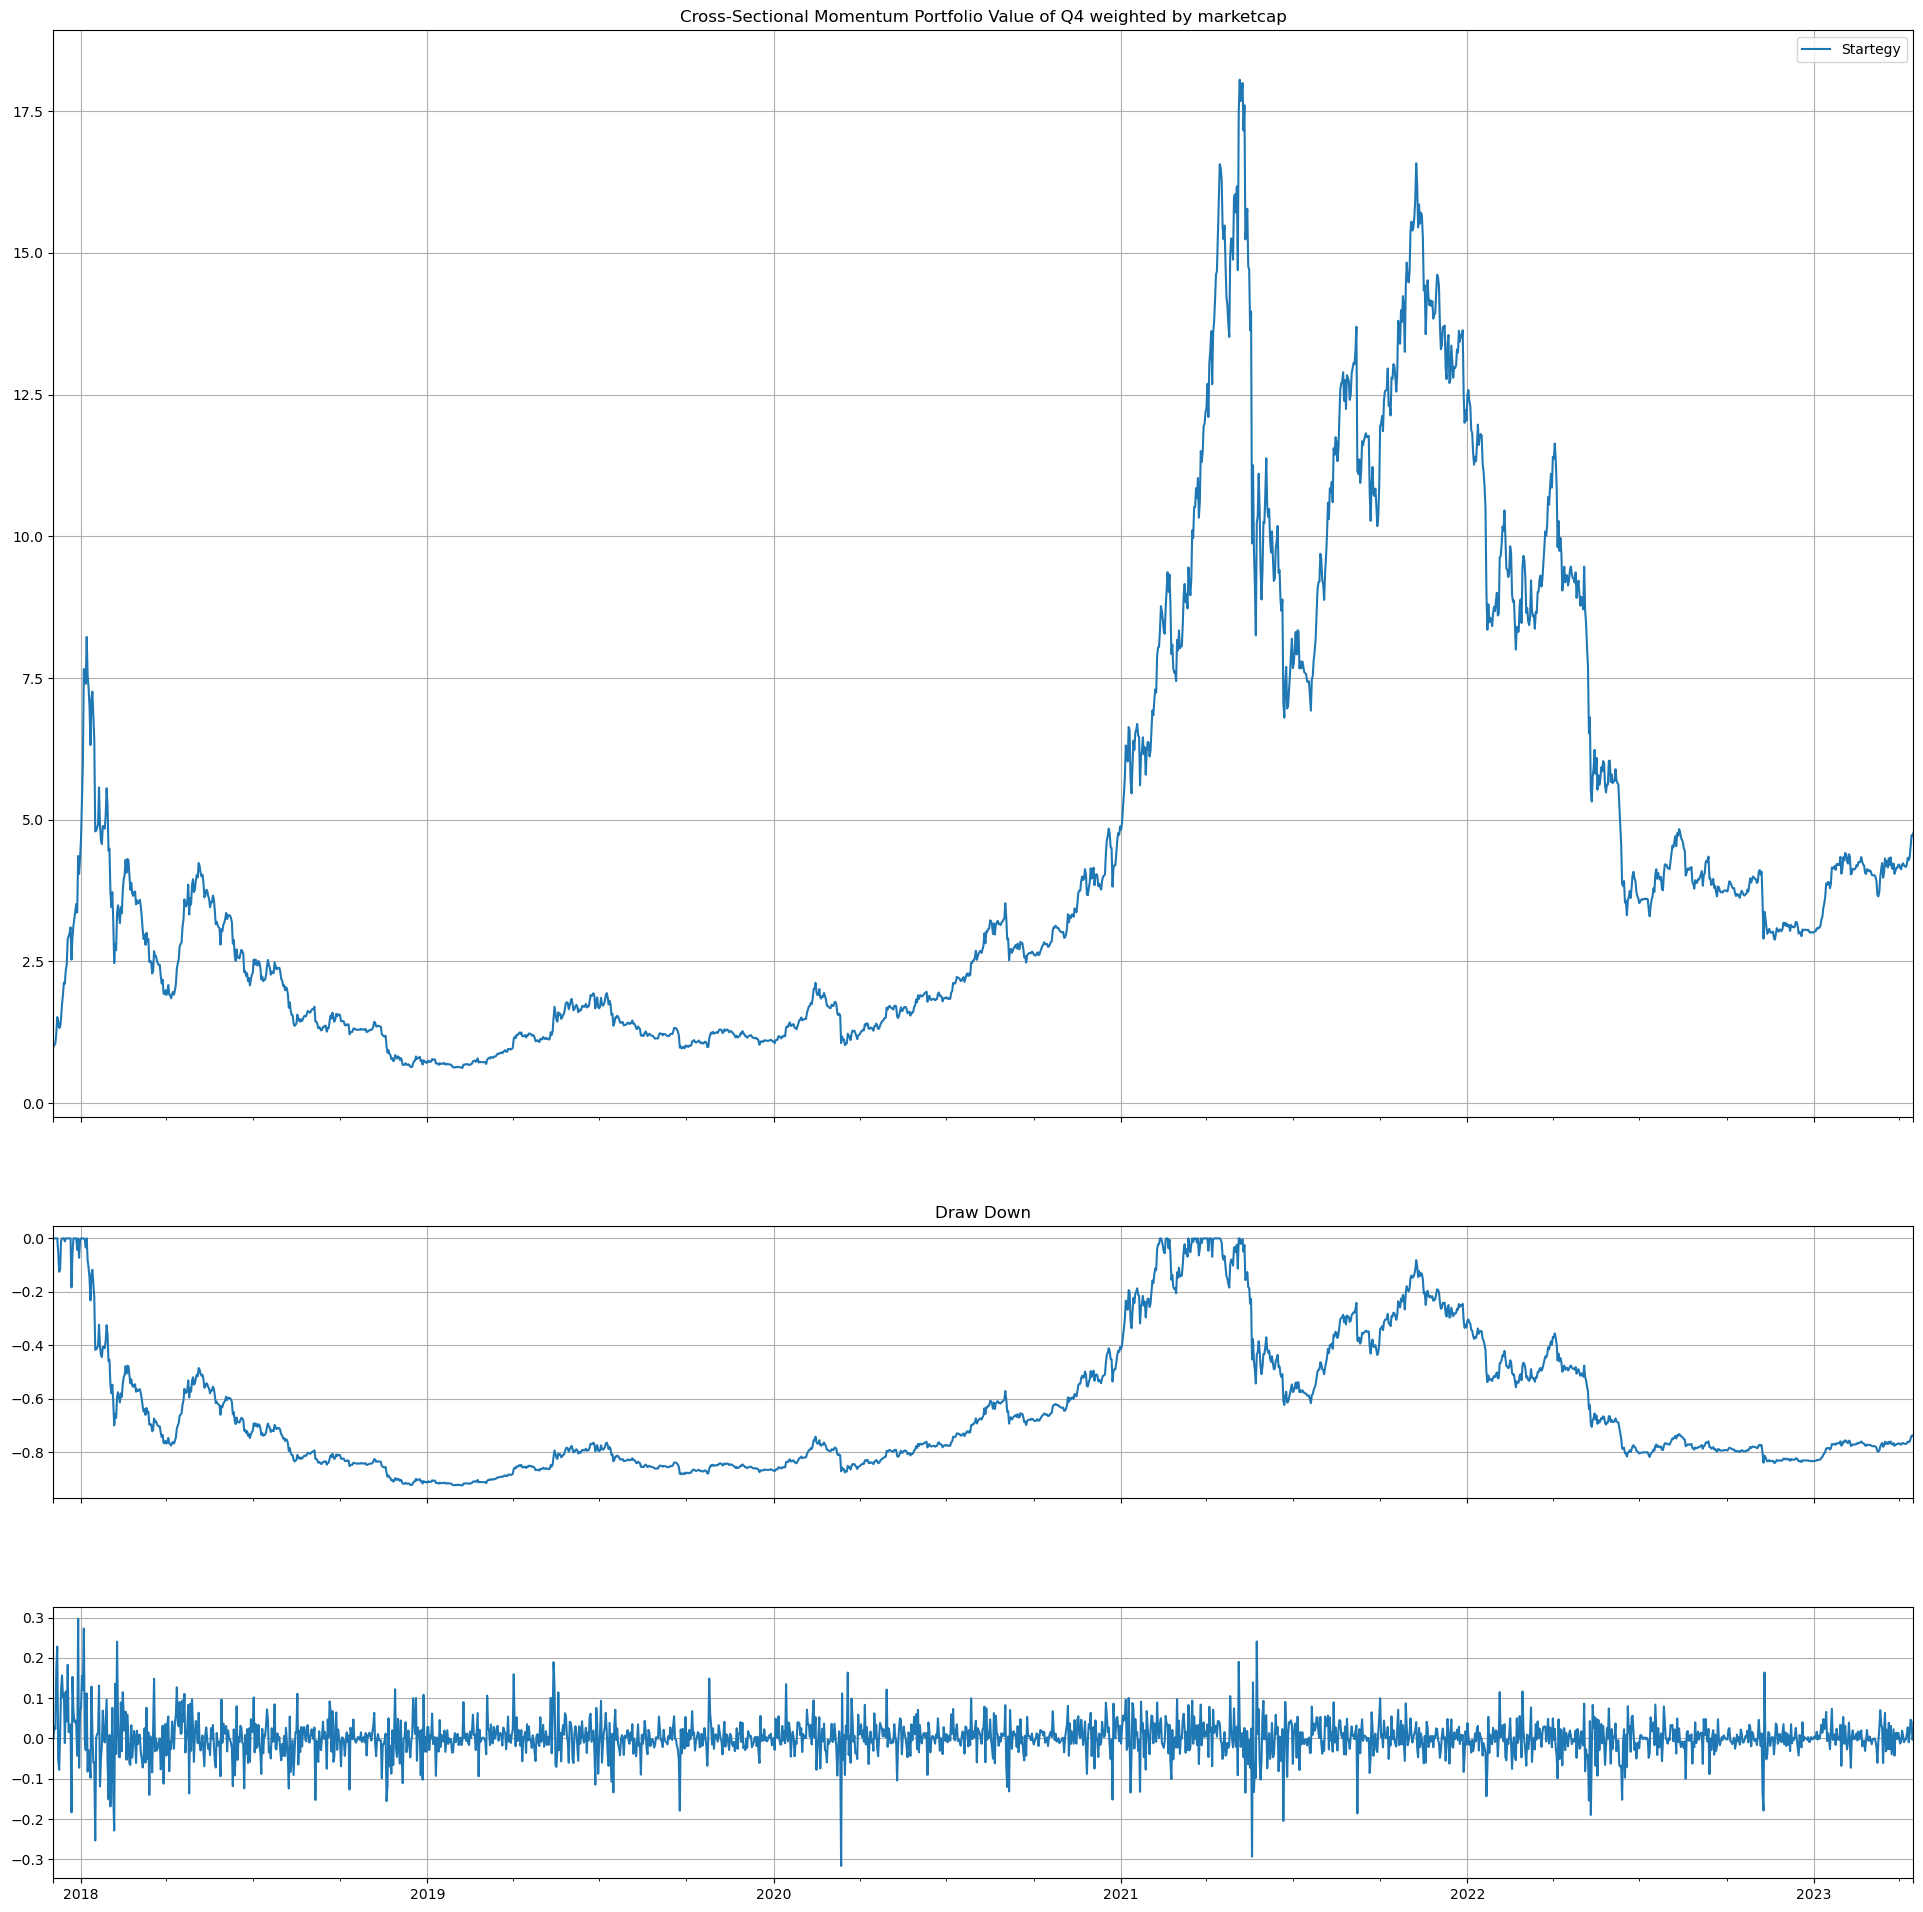

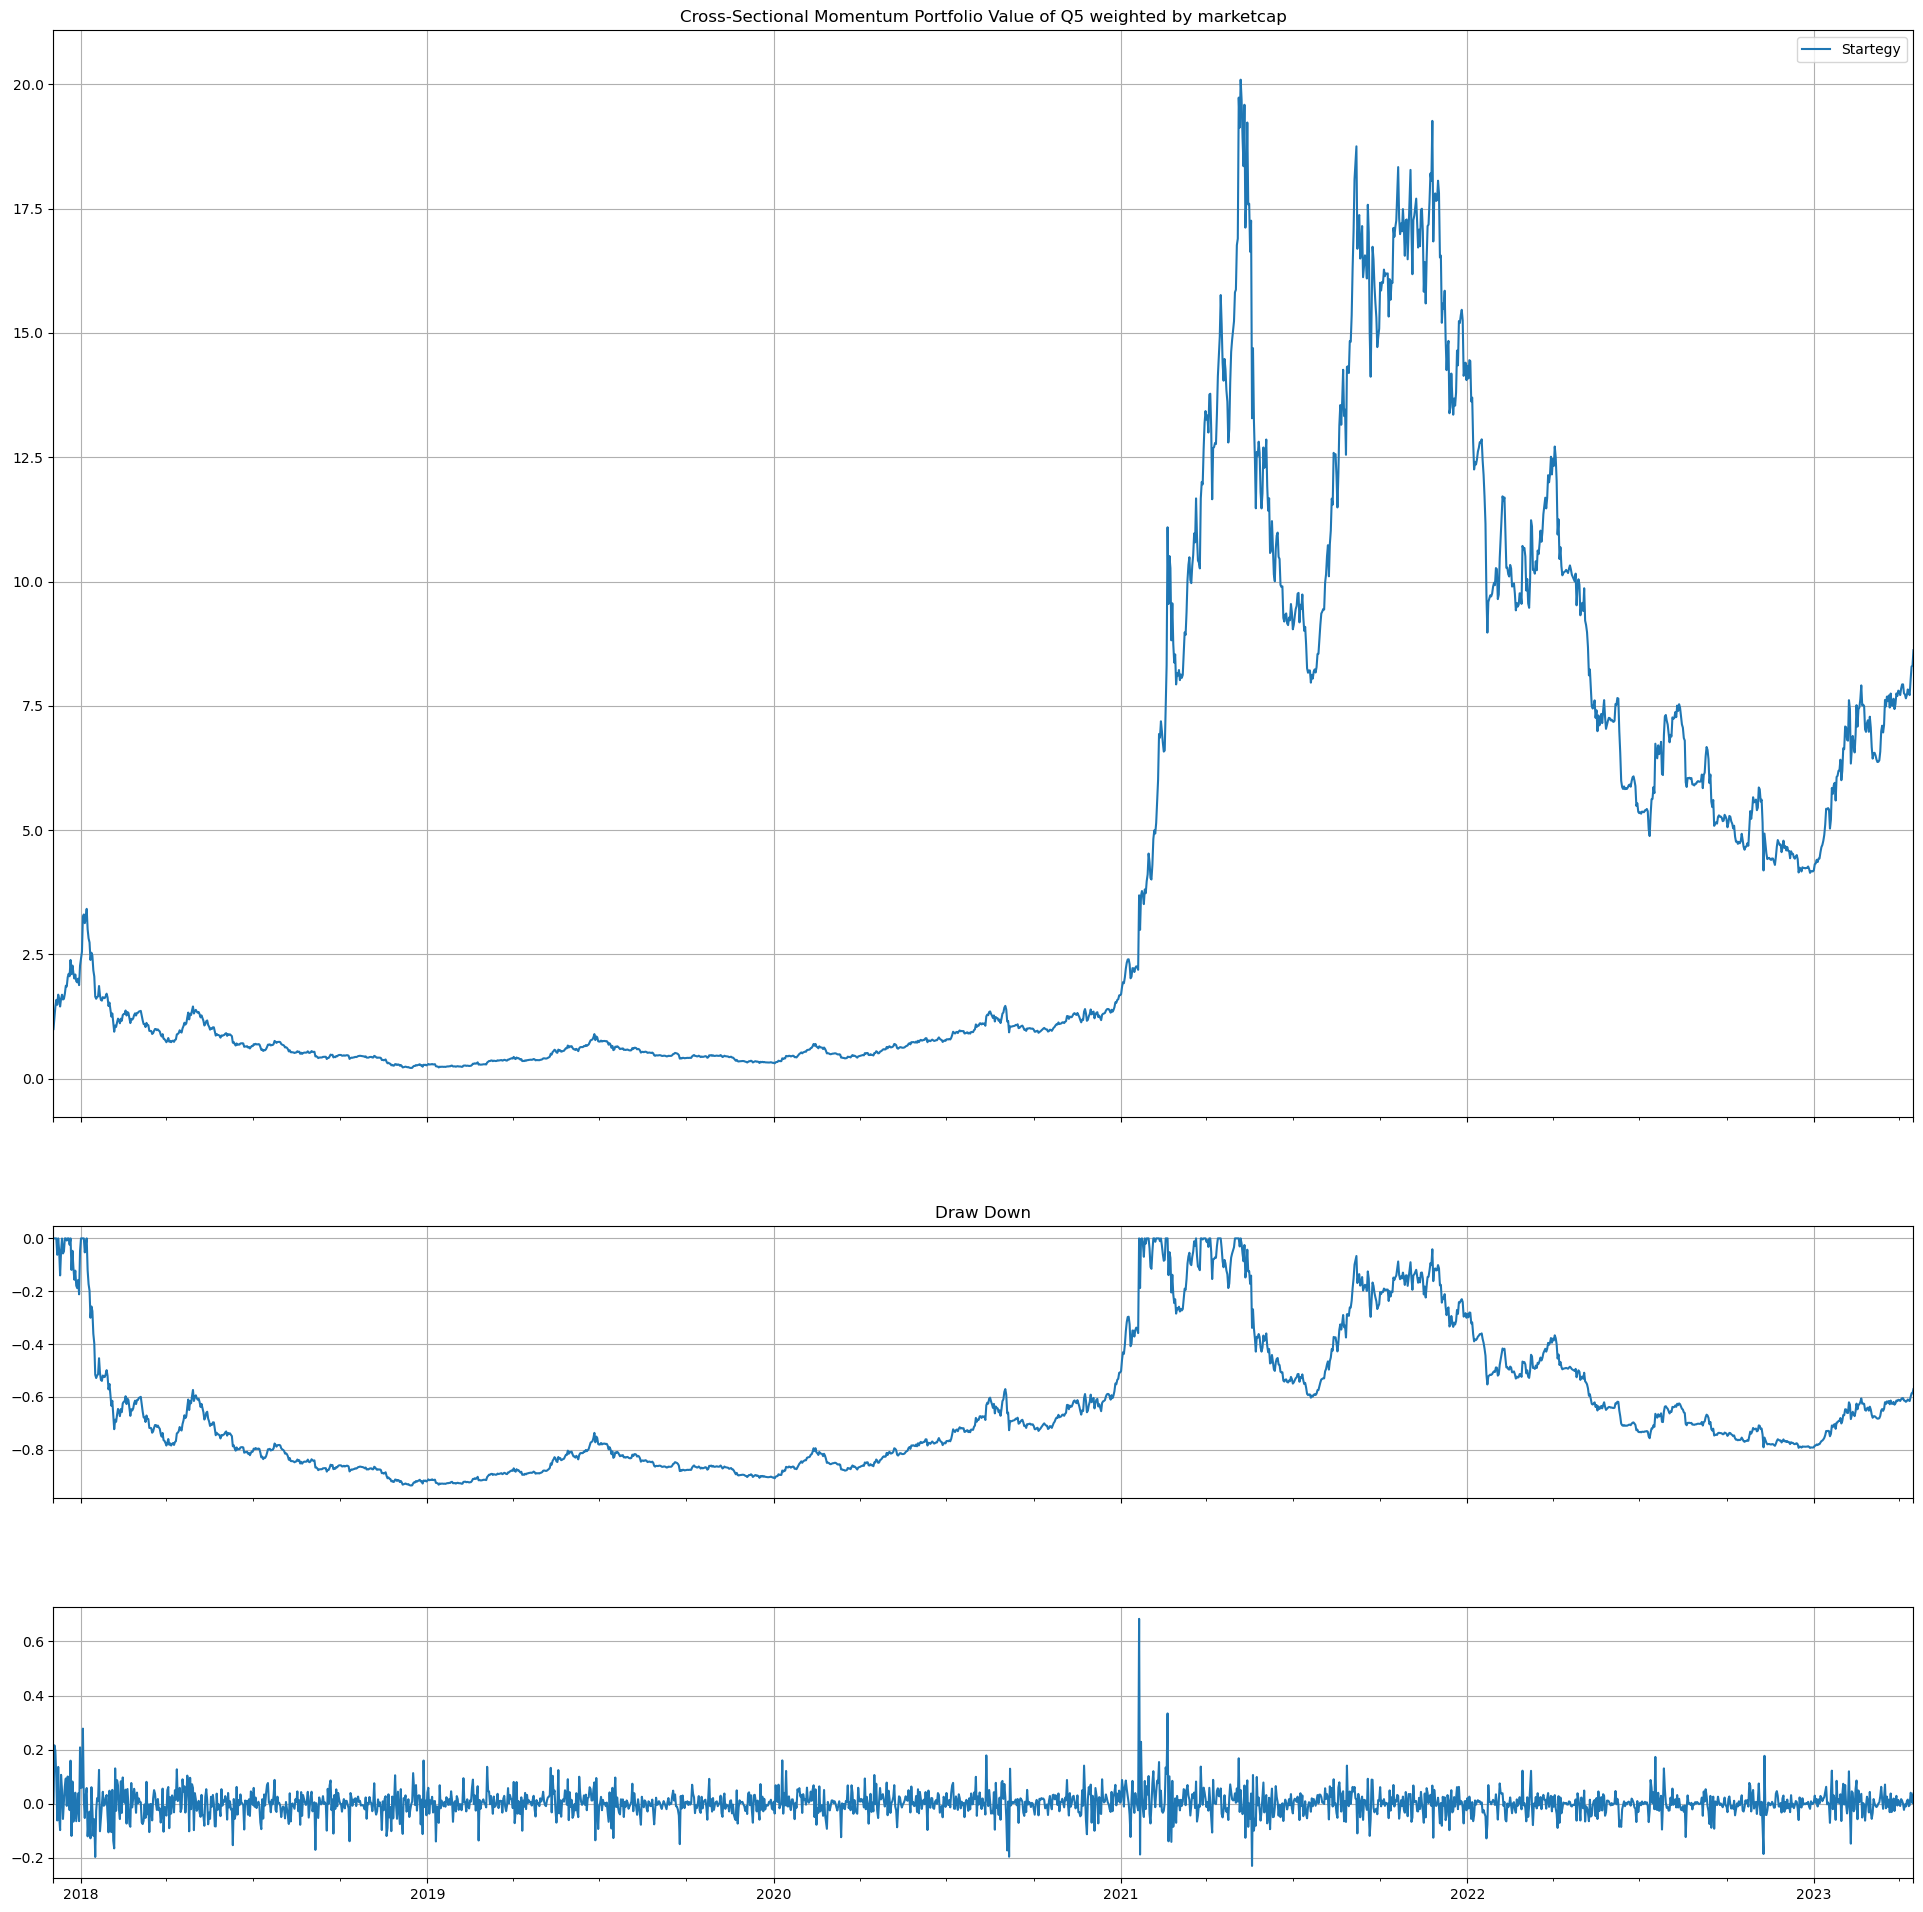

In [14]:
mytool.draw_return_result(final_value)

In [15]:
mytool.print_statistics(final_value)

,0,1,2,3,4
CAGR,-73.2256%,-15.5712%,4.6626%,33.048%,44.0105%
Mean,-0.782683,0.293308,0.415966,0.699961,0.829075
STD,1.011457,0.948541,0.831928,0.89866,0.939925
Sharpe,-0.773818,0.30922,0.500002,0.778894,0.882065
